In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy import stats
from tqdm import tqdm

In [171]:
inputFile = "MAESTRO-d6178bdd-identified_variants_merged_protein_regions-main.tsv"
data = pd.read_csv(inputFile,sep='\t',low_memory=False)

In [212]:
data_processed = data[['Peptide'] + [c for c in data.columns if 'intensity_for_peptide_variant' in c]]

In [213]:
data_processed.replace(0.0,np.nan, inplace = True)

/home/aditya/.local/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [214]:
data_processed = data_processed.set_index("Peptide")

In [215]:
data_processed = data_processed.T

In [216]:
data_processed.index = data_processed.index.map(lambda x:'.'.join(x.split('.')[:2]))

In [217]:
def create_label(x):
    if "#Healthy" in x:
        return 1
    elif "#Non-severe-COVID-19" in x:
        return 2
    elif "#Severe-COVID-19" in x:
        return 3
    elif "#Symptomatic-non-COVID-19" in x:
        return 4
    else:
        return 0
data_processed["label"]=data_processed.index.map(lambda x: create_label(x))

In [218]:
data_processed = data_processed[data_processed['label']!=0]

In [219]:
#Split Train and Test data after shuffling 
#data_processed.dropna(axis=1,inplace=True)
data_processed = data_processed.sample(frac=1)
train = data_processed.iloc[:66,:]
test = data_processed.iloc[66:,:]

In [220]:
#Filter Data based on NaN for each label in training data
per_label_count = train.groupby('label').count()
filterCondition = (per_label_count >= 13).all()
filter_per_label = per_label_count.loc[:, filterCondition]
filter_column = list(filter_per_label.columns) +['label']
filter_data =  train[filter_column]

In [221]:
for column in tqdm(filter_data):
    if column != "label":
        filter_data[column] = filter_data.groupby("label")[column].transform(lambda x: x.fillna(x.mean()))

  0%|                                                                                                                                                                               | 0/66 [00:00<?, ?it/s]/tmp/ipykernel_1144054/3972711595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data[column] = filter_data.groupby("label")[column].transform(lambda x: x.fillna(x.mean()))
11737it [00:33, 349.24it/s]                                                                                                                                                                                


In [222]:
##filter_data.to_csv("filterd_data.tsv", sep="\t")
filter_data.shape

(66, 11737)

In [183]:
#filter_data = train

In [223]:
#Correlation Matrix
data_correlated = filter_data.corr()
corr_matrix = data_correlated.abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]


/tmp/ipykernel_1144054/3173281684.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


In [224]:
print(len(to_drop))
filter_data = filter_data.drop(columns=to_drop)

6617


In [225]:
##Ttest 
from itertools import combinations
from scipy import stats
from collections import defaultdict

grouped_df = filter_data.groupby('label')
label_key = list(grouped_df.groups.keys())
peptide_key = list(grouped_df.get_group(label_key[0]).keys())


def ttest_run(c1, c2):
    results = stats.ttest_ind(c1, c2, equal_var=False, alternative='two-sided')
    if results.pvalue < 0.05:
        return 1
    return 0
    

imp = []
for p in tqdm(peptide_key):
    group_peptide = defaultdict(dict)
    for k in label_key: 
        group_peptide[k] = grouped_df.get_group(k)[p]
    
    ttest = [ttest_run(list(group_peptide[i]),list(group_peptide[j])) for i, j in combinations(label_key, 2)]
    if sum(ttest) > 0:
        imp.append(p)

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5120/5120 [00:19<00:00, 262.01it/s]


In [226]:
filter_data_ttest = filter_data[imp]

In [233]:
test1 = test[filter_data_ttest.columns]
test1 = test1.fillna(0.0)

In [234]:
## Logistic Regression 
X_train, Y_train = filter_data_ttest.iloc[:,:-1], filter_data_ttest.iloc[:,-1]
X_test, Y_test = test1.iloc[:,:-1], test1.iloc[:,-1]

In [239]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  classification_report

# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [236]:
lr = LogisticRegression(random_state=20)
lr.fit(X_train,Y_train)

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=20)

In [240]:
lr_Y = lr.predict(X_test)
lr_acc = accuracy_score(Y_test, lr_Y)
print(lr_acc)
print(classification_report(Y_test, lr_Y))

0.8333333333333334
              precision    recall  f1-score   support

           1       0.80      1.00      0.89         8
           2       0.75      0.60      0.67         5
           3       0.80      0.80      0.80         5
           4       1.00      0.83      0.91         6

    accuracy                           0.83        24
   macro avg       0.84      0.81      0.82        24
weighted avg       0.84      0.83      0.83        24



In [238]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)
rf_acc = accuracy_score(Y_test, y_pred)
rf_acc

0.5833333333333334

In [89]:
Y_test 

_dyn_#Severe-COVID-19.XG27                           3
_dyn_#Symptomatic-non-COVID-19.JBDZ22                4
_dyn_#Severe-COVID-19.Patient-group-ZX               3
_dyn_#Non-severe-COVID-19.XG17                       2
_dyn_#Severe-COVID-19.XG36                           3
_dyn_#Symptomatic-non-COVID-19.JBDZ11                4
_dyn_#Non-severe-COVID-19.XG1                        2
_dyn_#Non-severe-COVID-19.XG25                       2
_dyn_#Healthy.HC25                                   1
_dyn_#Symptomatic-non-COVID-19.JBDZ5                 4
_dyn_#Healthy.HC20                                   1
_dyn_#Symptomatic-non-COVID-19.JBDZ1                 4
_dyn_#Severe-COVID-19.XG38                           3
_dyn_#Healthy.HC26                                   1
_dyn_#Symptomatic-non-COVID-19.JBDZ3                 4
_dyn_#Symptomatic-non-COVID-19.JBDZ17                4
_dyn_#Severe-COVID-19.XG40                           3
_dyn_#Non-severe-COVID-19.XG9                        2
_dyn_#Heal

[]

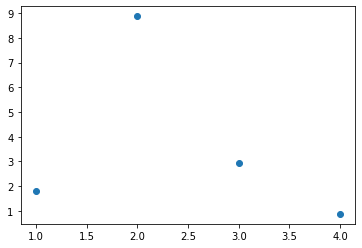

In [71]:
import matplotlib.pyplot as plt

y = filter_data[['-.[304.207](L,43.006)(K,304.207)(C,57.021)DEWSVNSVG(K,304.207).I', 'label']]
val = y.groupby('label').mean()
plt.scatter(list(val.index),list(val.values))
plt.plot()

In [72]:
val.values

array([[1.80641454],
       [8.87895734],
       [2.9422658 ],
       [0.87075176]])

In [241]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [242]:
lr1 = LogisticRegression(random_state=20)

In [243]:
min_features_to_select = 800  # Minimum number of features to consider
rfecv = RFECV(
    estimator=lr1,
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)

In [244]:
rfecv.fit(X_train, Y_train)
rfecv_Y = rfecv.predict(X_test)
rfecv_acc = accuracy_score(Y_test, rfecv_Y)
rfecv_acc


/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

0.8333333333333334

In [245]:
rfecv_acc

0.8333333333333334

In [246]:
imp

['K.[304.207]DLLF(R,-18.004)DDTV(C,57.021)LA(K,304.207).L',
 'D.[215.050]LLFRDDTV(C,57.021)LA(K,304.207).L',
 'R.[304.207](K,304.207)PVEEYAN(C,57.021)HLAR.A',
 'K.[304.207]NLNE(K,304.207)DYELL(C,57.021)LD.G',
 'K.{16.002}[304.207]NLNE(K,304.207)DYELL(C,57.021)LDGTR.K',
 'K.{95.076}[304.207]NLNE(K,304.207)DYEL.L',
 'R.[304.207](K,304.207)PVEE(Y,44.99)AN(C,57.021)HLAR.A',
 'R.[304.207](K,304.207)(P,37.954)VEEYAN(C,57.021)HLAR.A',
 'V.[304.207](E,-61.082)EYAN(C,57.021)HLAR.A',
 'R.[304.207]APN(H,57.025)AVVTR.K',
 'L.[304.207](N,22.941)E(K,304.207)DYELL(C,57.021)LDGTR.K',
 'R.{52.928}[304.207]FDEFFSEG(C,57.021)APGS(K,304.207)(K,304.207).D',
 'R.[304.207]FDEFFSEG(C,57.021)APG(S,228.116).K',
 'R.[304.207]FDEFFSEG(C,57.021)APGS(K,198.099)(K,304.207).D',
 'K.{52.918}[304.207]L(C,57.021)MGSGLNL(C,57.021)EPNN(K,304.207).E',
 'K.{17.026}[304.207]L(C,57.021)MGSGLNL(C,57.021)EPNN(K,304.207).E',
 'R.[304.207]FDEFF(S,52.918)EG(C,57.021)APGS(K,304.207).K',
 'R.[304.207]FDEFFSEG(C,377.232)APGS(K,304.20